In [1]:
from datasets import load_dataset
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch_geometric as pyg
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [2]:
dataset_hf = load_dataset("graphs-datasets/PROTEINS")
dataset_pg_list = [
    Data(
        x=torch.tensor(graph["node_feat"]),
        edge_index=torch.tensor(graph["edge_index"]),
        y=torch.tensor(graph["y"]),
    ) for graph in dataset_hf["train"]
]
dataset_pg = DataLoader(dataset_pg_list)

In [6]:
print(f"Number of graphs in the dataset: {len(dataset_pg_list):,}")

Number of graphs in the dataset: 1,113


In [7]:
prot = dataset_pg_list[0]

In [8]:
prot.is_undirected()

True

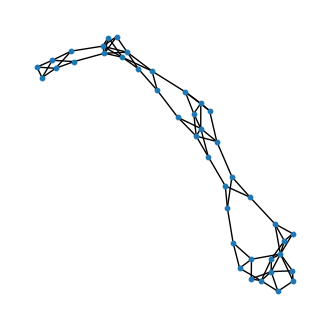

In [9]:
nxg = pyg.utils.to_networkx(prot, to_undirected=True)
fig = plt.figure(figsize=(4, 4))
nx.draw(nxg, node_size=10, ax=fig.add_subplot(111))

In [15]:
prot.x.shape

torch.Size([42, 3])

In [23]:
samples = []
colors = []
for i in np.random.randint(0, len(dataset_pg_list), 9):
    samples.append(pyg.utils.to_networkx(dataset_pg_list[i], to_undirected=True))
    colors.append("blue" if dataset_pg_list[i].y.item() == 1 else "red")

<Figure size 1200x1200 with 0 Axes>

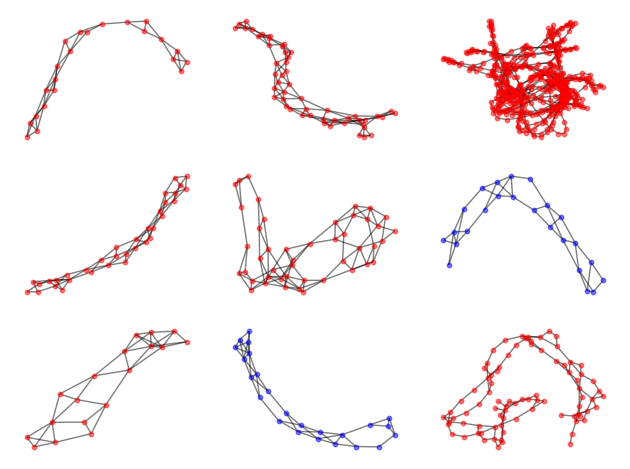

In [24]:
# Set the figure size
plt.figure(figsize=(12, 12))

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3)

# Iterate over the samples and plot each graph
for i, (sample, color) in enumerate(zip(samples, colors)):
    # Get the current subplot axes
    ax = axes[i // 3, i % 3]
    
    # Customize the node size
    node_size = 10
    
    # Customize the node color
    node_alpha = 0.5
    
    # Plot the graph
    nx.draw(sample, ax=ax, node_size=node_size, node_color=color, alpha=node_alpha)
    
# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [30]:
sum([g["y"][0] for g in dataset_hf["train"]]) / len(dataset_hf["train"])

0.40431266846361186

In [6]:
stats = pd.DataFrame(dict(
    num_nodes=[g["num_nodes"] for g in dataset_hf["train"]],
    num_edges=[len(g["edge_index"][0]) for g in dataset_hf["train"]],
    y=[g["y"][0] for g in dataset_hf["train"]]
))
stats['avg_deg'] = stats['num_edges'] / stats['num_nodes']
stats['diameter'] = np.nan
for i, g in enumerate(dataset_pg_list):
    try:
        stats.loc[i, 'diameter'] = nx.diameter(pyg.utils.to_networkx(g, to_undirected=True)) 
    except nx.NetworkXError:
        pass

<Axes: >

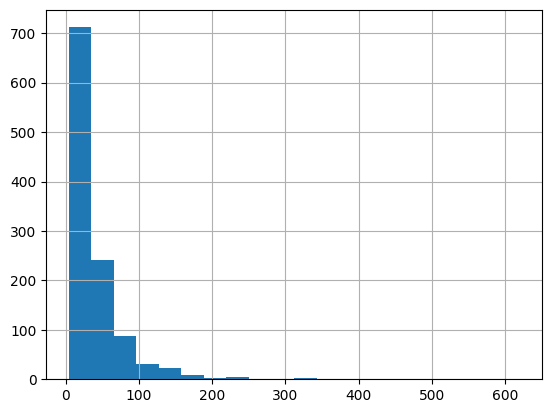

In [7]:
stats.num_nodes.hist(bins=20)

<Axes: >

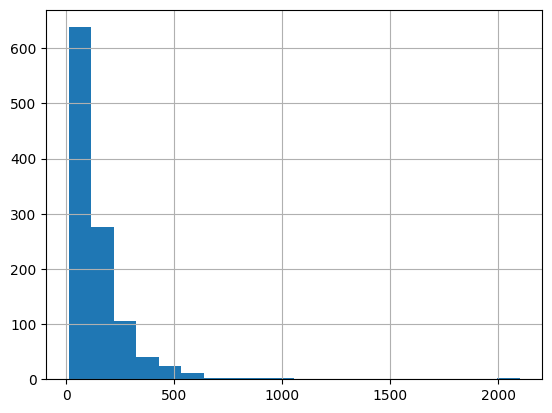

In [8]:
stats.num_edges.hist(bins=20)

<Axes: >

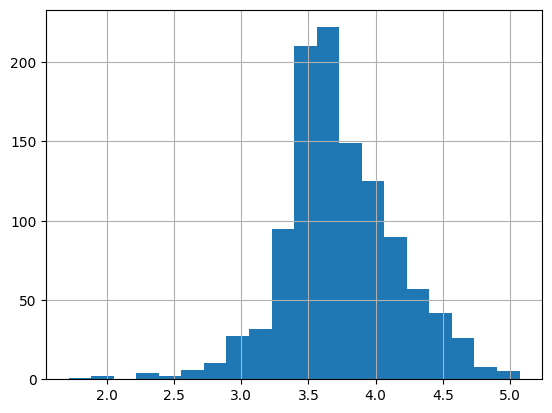

In [9]:
stats.avg_deg.hist(bins=20)

<Axes: >

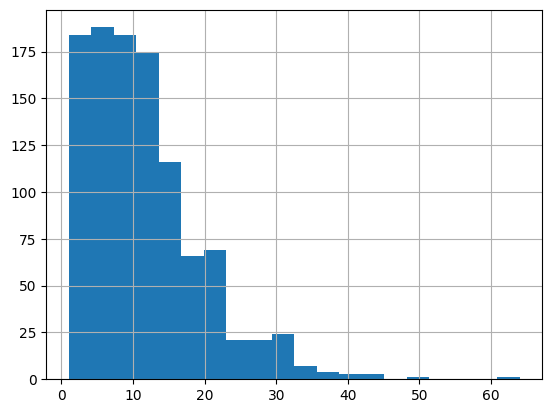

In [10]:
stats.diameter.hist(bins=20)

In [17]:
stats.y.value_counts(normalize=True)

y
0    0.595687
1    0.404313
Name: proportion, dtype: float64

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_85816/2638255679.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats.groupby(pd.qcut(stats.num_nodes, 10)).y.mean().plot(kind='bar')


<Axes: xlabel='num_nodes'>

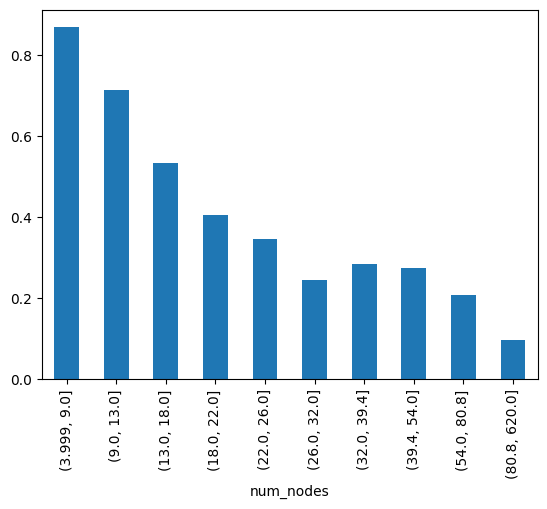

In [20]:
stats.groupby(pd.qcut(stats.num_nodes, 10)).y.mean().plot(kind='bar')

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_85816/605421235.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats.groupby(pd.qcut(stats.num_edges, 10)).y.mean().plot(kind='bar')


<Axes: xlabel='num_edges'>

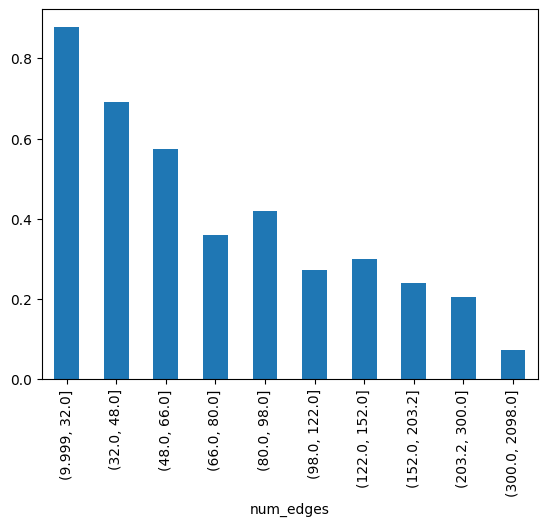

In [22]:
stats.groupby(pd.qcut(stats.num_edges, 10)).y.mean().plot(kind='bar')

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_85816/307121434.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats.groupby(pd.qcut(stats.avg_deg, 10)).y.mean().plot(kind='bar')


<Axes: xlabel='avg_deg'>

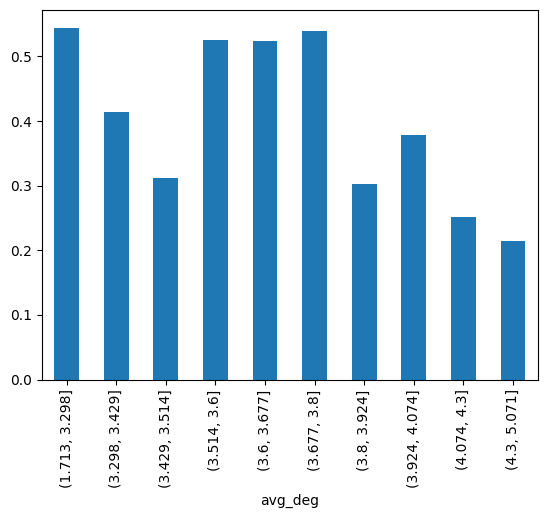

In [23]:
stats.groupby(pd.qcut(stats.avg_deg, 10)).y.mean().plot(kind='bar')

/var/folders/08/91_vkqq52qg5phplpcj85z480000gn/T/ipykernel_17359/3502375203.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stats.groupby(pd.qcut(stats.diameter, 10)).y.mean().plot(kind='bar')


<Axes: xlabel='diameter'>

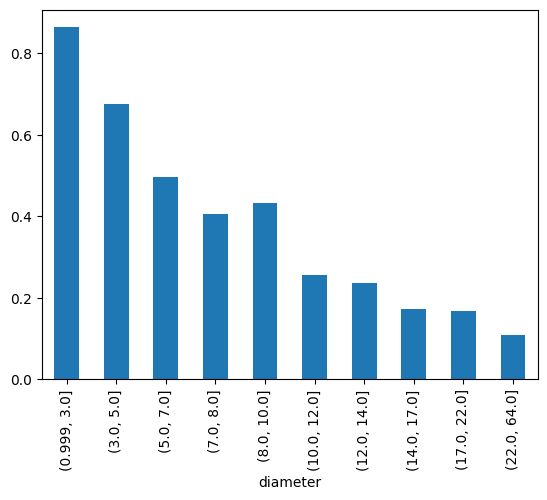

In [11]:
stats.groupby(pd.qcut(stats.diameter, 10)).y.mean().plot(kind='bar')

In [12]:
stats.describe()

,num_nodes,num_edges,y,avg_deg,diameter
count,1113.000000,1113.000000,1113.000000,1113.000000,1067.000000
mean,39.057502,145.631626,0.404313,3.734642,11.624180
std,45.778992,169.274151,0.490979,0.424003,7.924023
min,4.000000,10.000000,0.000000,1.714286,1.000000
25%,15.000000,56.000000,0.000000,3.476923,6.000000
50%,26.000000,98.000000,0.000000,3.677419,10.000000
75%,45.000000,174.000000,1.000000,4.000000,15.000000
max,620.000000,2098.000000,1.000000,5.071429,64.000000


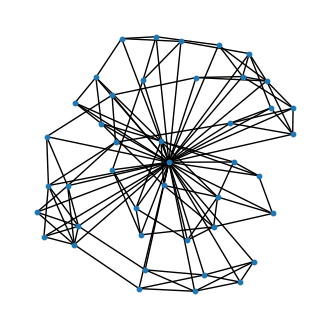

In [10]:
vnode_transform = pyg.transforms.VirtualNode()
prot2 = vnode_transform(prot)
fig = plt.figure(figsize=(4, 4))
nx.draw(pyg.utils.to_networkx(prot2, to_undirected=True), node_size=10, ax=fig.add_subplot(111))

In [11]:
prot2.x[-1]

tensor([0., 0., 0.])

In [12]:
prot2

Data(x=[43, 3], edge_index=[2, 246], y=[1], edge_type=[246])

In [13]:
prot

Data(x=[42, 3], edge_index=[2, 162], y=[1])

In [14]:
prot2.edge_type

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [41]:
dataset_pg = DataLoader(dataset_pg_list, batch_size=8, shuffle=False)
batch = next(iter(dataset_pg))

In [42]:
batch

DataBatch(x=[712, 3], edge_index=[2, 3102], y=[8], batch=[712], ptr=[9])

In [48]:
batch.ptr[1:] - 1

tensor([ 41,  68,  78, 102, 113, 449, 557, 711])

In [47]:
batch.batch[42]

tensor(1)

In [105]:
n = 10
r = 0.4
contribs = torch.tensor([1.5e5, 1e5, 1e5, 2e5, 2e5, 2e5, 3e5, 3e5, 3e5, 3e5])[:n]
rets = (1 + r) ** (torch.arange(n) + 1)
b = (contribs * rets)
print(b)
print()
print(f'${int(b.sum().item()):,}')

tensor([ 210000.0000,  195999.9844,  274400.0000,  768319.9375, 1075647.8750,
        1505907.0000, 3162404.7500, 4427366.5000, 6198313.0000, 8677638.0000])

$26,495,994


In [85]:
rets

tensor([1.4000, 1.9600, 2.7440, 3.8416, 5.3782])